In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.datasets import make_classification

%matplotlib inline

# Prepare dataset

We generate same toy data set for learning.

In [2]:
dataset = make_classification(
    n_samples=10000, n_features=3, n_informative=3, n_redundant=0, weights=[0.9, 0.1], random_state=2016
)

df = pd.DataFrame({
        'feature1': dataset[0][:, 0], 
        'feature2': dataset[0][:, 1], 
        'feature3': dataset[0][:, 2],
        'target': dataset[1]
})

df.head()

,feature1,feature2,feature3,target
0,-0.603517,0.356539,1.498061,0
1,-1.495687,0.795037,-0.732101,0
2,-0.095506,0.487563,0.446223,0
3,-0.140712,2.260213,-1.507246,0
4,-0.739288,0.971696,2.929825,0


We see imbalanced class. For our purpose, we select online two class 6 and 7.

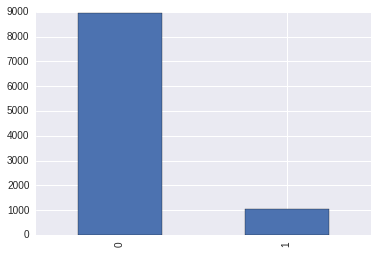

In [3]:
df.target.value_counts().plot(kind='bar')

In [4]:
df.target.value_counts()

0    8962
1    1038
Name: target, dtype: int64

## Modeling without dealing with imbalanced data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('target', axis=1), df.target, train_size=0.8, random_state=42
)

In [6]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [7]:
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred, labels=[0, 1])

array([[1763,   39],
       [  84,  114]])

In [8]:
roc_auc_score(y_test, y_pred)

0.77705747822284998

We can use class_weight parameter, but we want to learn new method for imbalanced data.

## Class weight in Scikit learn

In [9]:
model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred, labels=[0, 1])

array([[1609,  193],
       [  32,  166]])

In [10]:
roc_auc_score(y_test, y_pred)

0.86564030986894458

### How it works

It is inversely proportional to the number of samples in the class.

You can compute old way.

In [11]:
classes = y_train.unique().tolist()
classes

[0, 1]

In [12]:
bincounts = np.bincount(y_train)
bincounts

array([7160,  840])

In [13]:
recip_freq = 1.0 / bincounts
recip_freq

array([ 0.00013966,  0.00119048])

In [14]:
weights = recip_freq / np.mean(recip_freq)
weights

array([ 0.21,  1.79])

Or new way. Based on Logistic Regression in Rare Events Data, King, Zen, 2001.

In [15]:
weights = len(y_train) / (len(classes) * np.bincount(y_train).astype(float))
weights

array([ 0.55865922,  4.76190476])

Basically, it changes regularized parameter of C.

weights[i] * C

# Undersampling

We distinguish two undersampling methods: informative and random. Informative undersampling are Easy Ensemble and Balance Cascade. In random undersampling we remove observations from majority class.

## Random sampling

We get randomly subset from majority class.

In [16]:
idx = y_train[y_train == 1].index
X_pos = X_train.ix[idx]
y_pos = y_train.ix[idx]

idx = y_train[y_train == 0].sample(X_pos.shape[0], random_state=42, replace=True).index
X_train_sample, y_train_sample = X_pos.append(X_train.ix[idx]), y_pos.append(y_train.ix[idx])

model = LogisticRegression()
model.fit(X_train_sample, y_train_sample)

y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred, labels=[0, 1])

array([[1610,  192],
       [  31,  167]])

In [17]:
roc_auc_score(y_test, y_pred)

0.86844303187255456

## Easy Ensemble

We need to get several subsets of independend sample. It means, that you need to take sample with replacement from majority class.

In [18]:
minority_df = df[df.target == 1]
majority_df_sample = df[df.target == 0].sample(minority_df.shape[0], random_state=42, replace=True)
majority_df_sample.shape

(1038, 4)

Now we can learn some classifiers.

In [19]:
estimators = []
idx = y_train[y_train == 1].index
X_pos = X_train.ix[idx]
y_pos = y_train.ix[idx]

for _ in range(10):
    idx = y_train[y_train == 0].sample(X_pos.shape[0], random_state=_, replace=True).index
    
    model = LogisticRegression() 
    model.fit(X_pos.append(X_train.ix[idx]), y_pos.append(y_train.ix[idx]))
    
    estimators.append(('model_{}'.format(_), model))

We predict probabilities.

In [20]:
def predict(X_test, y_test, estimators):
    predictions = pd.DataFrame({'target': y_test})

    for name, estimator in estimators:
        predictions[name] = estimator.predict_proba(X_test)[:, 1]

    predictions['probability'] = np.mean(predictions.drop('target', axis=1), axis=1)
    predictions['prediction'] = predictions.probability.map(lambda x: x >= 0.5).astype(int)
    
    return predictions

predictions = predict(X_test, y_test, estimators)
predictions.head()

,target,model_0,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,probability,prediction
6252,0,0.063087,0.060935,0.066279,0.061937,0.062220,0.049114,0.069966,0.055956,0.063711,0.071944,0.062515,0
4684,0,0.097122,0.082928,0.075329,0.080534,0.096940,0.102710,0.089321,0.078630,0.091222,0.082149,0.087688,0
1731,0,0.098516,0.096614,0.103774,0.098478,0.100060,0.083587,0.106333,0.089473,0.100943,0.111439,0.098922,0
4742,1,0.975798,0.982201,0.972058,0.975798,0.972422,0.987252,0.975734,0.982312,0.969625,0.973321,0.976652,1
4521,0,0.056774,0.051899,0.054572,0.052749,0.056596,0.047034,0.059536,0.047905,0.056643,0.059479,0.054319,0


In [21]:
confusion_matrix(y_test, predictions.prediction, labels=[0, 1])

array([[1608,  194],
       [  32,  166]])

In [22]:
roc_auc_score(y_test, predictions.prediction)

0.86536284039058731

Result of this exercise is almost equal to result from weight class in Logistic Regression above.

## Balance Cascade

In Balance Cascade we split our dataset intu minority and majority sets. We get all data points from minority set and sample from majority. Next, we remove out training majority examples from majority set and we predict on remaining set.
We drop all correctly classified examples from majority_set.

In [23]:
estimators = []
minority_set = df.ix[X_train.index][y_train == 1]
majority_set = df.ix[X_train.index][y_train == 0]
iteration = 0

while majority_set.shape[0] > 0:
    sample_size = minority_set.shape[0]    
       
    if majority_set.shape[0] < sample_size:
        sample_size = majority_set.shape[0]

    idx = majority_set.sample(sample_size, random_state=42, replace=False).index
    
    X_train_sample = minority_set.append(majority_set.ix[idx]).drop('target', axis=1)
    y_train_sample = minority_set.append(majority_set.ix[idx]).target

    model = LogisticRegression()
    model.fit(X_train_sample, y_train_sample)
    estimators.append(('model_{}'.format(iteration), model))

    majority_set.drop(idx, inplace=True)
    
    if majority_set.shape[0] == 0:
        break    

    predictions = model.predict(majority_set.drop('target', axis=1))
    correctly_classified_examples = majority_set[predictions == majority_set.target]

    majority_set.drop(correctly_classified_examples.index, inplace=True)

In [24]:
predictions = predict(X_test, y_test, estimators)
predictions.head()

,target,model_0,probability,prediction
6252,0,0.138257,0.138257,0
4684,0,0.297494,0.297494,0
1731,0,0.217115,0.217115,0
4742,1,0.805808,0.805808,1
4521,0,0.162828,0.162828,0


Now, we can validate our ensemable methods.

In [25]:
confusion_matrix(y_test, predictions.prediction, labels=[0, 1])

array([[1602,  200],
       [  44,  154]])

In [26]:
roc_auc_score(y_test, predictions.prediction)

0.83339499321741273

In this methods above, we lose information from majority class.